HOLAS ;D

# Segundo acercamiento Esteganografía a partir de audio

Este segundo acercamiento se realiza con el objetivo de adquirir nuevamente el mensaje que se oculto por medio de métodos esteganograficos.

Se utiliza la estrategia de incrustar la información sobre el bit de menor relevancia.

También para esta segunda versión despues de realizar varias consultas se encuentra que:
- La librería que se utilizo anteriormente (pydub) genera bastantes inconsistencias con su forma de leer y sobreescribir el audio.
- El formato MP3 se diseña con el objetivo de que puedan perderse datos, en comparación a un audio de tipo wav el cual evita este problema.

In [1]:
import wave
import numpy as np

## Definición de funciones

### Función para cargar un archivo WAV y convertirlo a un array de numpy

In [2]:
def load_wav_file(filename):
    with wave.open(filename, 'rb') as wav_file:
        n_frames = wav_file.getnframes()
        audio_data = wav_file.readframes(n_frames)
        audio_array = np.frombuffer(audio_data, dtype=np.int16)
    return audio_array

### Función para guardar un array de numpy como un archivo WAV

In [3]:
def save_wav_file(filename, audio_array, params):
    with wave.open(filename, 'wb') as wav_file:
        wav_file.setparams(params)
        wav_file.writeframes(audio_array.tobytes())

### Función para incrustar un mensaje en un segmento de audio

#### Sin tener en cuenta el bit menos significativo

In [4]:
def embed_message_in_audio_segment(segment_array, message_bits):
    modified_segment_array = np.copy(segment_array)
    for i in range(len(message_bits)):
        sample_bin = format(segment_array[i], 'b')
        modified_sample_bin = sample_bin[:-1] + message_bits[i]
        modified_sample = int(modified_sample_bin, 2)
        modified_segment_array[i] = modified_sample
    return modified_segment_array

#### Teniendo en cuenta el bit menos significativo

In [5]:
def embed_message_in_audio_segment_based_on_lsb(segment_array, message_bits, num_least_significant_bits=1):
    modified_segment_array = np.copy(segment_array)

    least_significant_bits = get_least_significant_bits(segment_array, num_least_significant_bits)

    for i in range(len(message_bits)):
        sample_bin = format(segment_array[i], 'b').zfill(16)  # audio 16-bit
        lsb = least_significant_bits[i]

        # Reemplazando el bit menos significativo
        modified_sample_bin = sample_bin[:-len(lsb)] + message_bits[i]

        modified_sample = int(modified_sample_bin, 2)
        modified_segment_array[i] = modified_sample

    return modified_segment_array

### Función para extraer un mensaje de un segmento de audio

#### Sin tener en cuenta el bit menos significativo

In [6]:
def extract_message_from_audio_segment(segment_array, message_length):
    extracted_bits = ''.join([format(sample, 'b')[-1] for sample in segment_array[:message_length]])
    extracted_message = ''.join([chr(int(extracted_bits[i:i+8], 2)) for i in range(0, len(extracted_bits), 8)])
    return extracted_bits, extracted_message

#### Teniendo en cuenta el bit menos significativo

In [7]:
def extract_message_from_audio_segment_based_on_lsb(segment_array, message_length, num_least_significant_bits=1):
    least_significant_bits = get_least_significant_bits(segment_array, num_least_significant_bits)

    extracted_bits = ''.join(least_significant_bits[:message_length])

    extracted_message = ''.join([chr(int(extracted_bits[i:i+8], 2)) for i in range(0, len(extracted_bits), 8)])

    return extracted_bits, extracted_message

### Función para realizar la grafica de segmentos de audio

In [8]:
# IMportamos la libreria para realizar las gráficas
import matplotlib.pyplot as plt

In [9]:
# Función para realizar la gráfica del audio
def plot_audio_waveforms(original_audio, modified_audio, start_sample, end_sample):
    # Tamaño de la figura
    plt.figure(figsize=(15, 6))
    # Separación de figuras
    # Gráfica audio original
    plt.subplot(2, 1, 1)
    plt.title("Original Audio")
    plt.plot(original_audio[start_sample:end_sample])
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    # Gráfica audio modificaado
    plt.subplot(2, 1, 2)
    plt.title("Modified Audio")
    plt.plot(modified_audio[start_sample:end_sample])
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    # Mostrar la gráfica
    plt.tight_layout()
    plt.show()

### Función para determinar los bits menos significativos

In [10]:
# Funcion para obtener los bits menos significativos de una pista de audio
def get_least_significant_bits(segment_array, num_bits=1):
    least_significant_bits = [format(sample, 'b')[-num_bits:] for sample in segment_array]
    return least_significant_bits

## Manipulación del archivo

### Cargar el archivo de audo [Formato WAV]

In [11]:
audio_path = "/content/drive/MyDrive/Universidad/ZA PROYECTO DE GRADO/Tesis/Proyecto Final /UnoPorEllas.wav"
original_audio_array = load_wav_file(audio_path)

### Obtener los parámetros del archivo de audio original para usarlo al guardar el archivo modificado

In [12]:
with wave.open(audio_path, 'rb') as wav_file:
    params = wav_file.getparams()
    print(params)

_wave_params(nchannels=2, sampwidth=2, framerate=48000, nframes=9421056, comptype='NONE', compname='not compressed')


### Convertir el mensaje a una cadena de bits

In [13]:
message = "juferoga"

In [14]:
message = """

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec et sapien tincidunt, porta lacus at, pharetra mauris. In ullamcorper diam tortor, et ultricies leo eleifend a. Maecenas auctor porta feugiat. Vivamus pellentesque viverra venenatis. Ut sagittis augue eu ipsum luctus accumsan. Quisque sit amet odio vestibulum, maximus magna sit amet, gravida quam. Nullam ullamcorper sit amet mi vitae blandit. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Cras consectetur erat ipsum, sed sodales eros ultricies sed. Integer tempor augue quis libero interdum, in pharetra velit facilisis. Morbi elementum elementum posuere. Vivamus accumsan nulla eu mi elementum tincidunt.

Aliquam nec libero rutrum, sagittis mauris rhoncus, blandit tellus. Vivamus justo libero, faucibus vel tempor eu, lacinia non mi. Duis fringilla mauris orci, eu tincidunt nisi molestie in. Curabitur nisl nisl, tristique at neque ut, volutpat bibendum sem. Praesent non tincidunt nisl. Nulla pretium arcu gravida facilisis convallis. Ut tristique, ante placerat luctus sagittis, elit augue commodo mauris, eu sodales diam erat vel ante. Cras quis finibus urna, id mattis enim. Morbi feugiat dictum eros, at rhoncus felis molestie sed. Sed rutrum nibh et lectus auctor, sit amet ultricies mauris posuere. Morbi porttitor eros non est ornare dictum.

Aenean volutpat, leo in vestibulum tempus, elit odio bibendum quam, nec ultrices tortor ipsum sed odio. Proin quam odio, pretium vel placerat non, bibendum faucibus dolor. In tortor metus, volutpat id quam porta, maximus commodo elit. Aliquam id eleifend nibh, ac pretium nulla. Maecenas non ex varius, elementum eros placerat, fermentum urna. Duis dignissim, elit vel volutpat fermentum, urna sapien commodo sapien, consequat fermentum elit magna feugiat ex. Integer et pretium eros, accumsan feugiat orci. Donec nisi sapien, sollicitudin id mi a, tristique sodales purus. Vestibulum et gravida justo, ac elementum libero. Sed augue massa, bibendum ut felis ac, sollicitudin sodales ante. Mauris augue ex, viverra nec elit sed, pellentesque vulputate turpis. Donec facilisis, massa eu dictum luctus, enim nisl dapibus tortor, non tristique mauris quam commodo sem. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Aliquam iaculis ullamcorper arcu, ut ultrices magna condimentum eget. Vestibulum ultrices egestas libero, a tristique arcu pellentesque et. Fusce ultricies finibus odio, sed molestie diam feugiat quis.

Aliquam erat volutpat. Nunc quis nunc non metus condimentum vulputate. Phasellus eu vehicula mauris. Morbi faucibus cursus metus sed accumsan. Suspendisse potenti. Aenean varius efficitur lacus, sed faucibus metus molestie ac. In eros ex, dictum non viverra nec, semper nec ex. Sed vel libero et arcu ultrices tristique id eget est. Nulla nibh justo, ornare egestas rutrum eget, tincidunt et augue. Maecenas iaculis urna sit amet felis eleifend, at tempor purus mattis. Mauris tempus elit nunc, ac commodo tortor mollis sit amet. Quisque mattis libero sit amet nisl accumsan, sed finibus ex pellentesque.

Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Suspendisse eu enim ultrices nisi vehicula sodales. Fusce libero ligula, posuere ultricies libero laoreet, lacinia lacinia diam. Ut quis lacinia augue, eget ullamcorper eros. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nam eu velit tellus. Morbi vel auctor sem. Sed vitae aliquam dui, sed cursus dolor. Ut sit amet molestie risus, ac iaculis purus. """

In [15]:
message_bits = ''.join(format(ord(char), '08b') for char in message)
print(message, message_bits)



Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec et sapien tincidunt, porta lacus at, pharetra mauris. In ullamcorper diam tortor, et ultricies leo eleifend a. Maecenas auctor porta feugiat. Vivamus pellentesque viverra venenatis. Ut sagittis augue eu ipsum luctus accumsan. Quisque sit amet odio vestibulum, maximus magna sit amet, gravida quam. Nullam ullamcorper sit amet mi vitae blandit. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Cras consectetur erat ipsum, sed sodales eros ultricies sed. Integer tempor augue quis libero interdum, in pharetra velit facilisis. Morbi elementum elementum posuere. Vivamus accumsan nulla eu mi elementum tincidunt.

Aliquam nec libero rutrum, sagittis mauris rhoncus, blandit tellus. Vivamus justo libero, faucibus vel tempor eu, lacinia non mi. Duis fringilla mauris orci, eu tincidunt nisi molestie in. Curabitur nisl nisl, tristique at neque ut, volutpat bibendum sem. Praesent non tincidunt nisl. 

### Calcular el punto medio del audio en número de muestras

In [16]:
mid_point_samples = len(original_audio_array) // 2

In [17]:
len(original_audio_array)

18842112

In [18]:
mid_point_samples

9421056

### Tomar un segmento de audio

#### Alrededor del punto medio

In [19]:
segment_start_samples = mid_point_samples - 22050
segment_end_samples = mid_point_samples + 22050
original_segment_array = original_audio_array[segment_start_samples:segment_end_samples]

#### Todo el audio

In [20]:
original_segment_array_complete = original_audio_array[0:len(original_audio_array)]

### Incrustar el mensaje en el segmento de audio

#### Al rededor del punto medio

In [21]:
modified_segment_array = embed_message_in_audio_segment_based_on_lsb(original_segment_array, message_bits)

<ipython-input-5-59586ff46f23>:14: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -32769 to int16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  modified_segment_array[i] = modified_sample


#### En el audio completo

In [22]:
modified_audio_array_complete = embed_message_in_audio_segment_based_on_lsb(original_segment_array_complete, message_bits)

### Reemplazar el segmento original con el segmento modificado

#### Al rededor del punto medio

In [23]:
modified_audio_array = np.concatenate([original_audio_array[:segment_start_samples], modified_segment_array, original_audio_array[segment_end_samples:]])

#### En el audio completo

In [24]:
modified_audio_array_complete = np.concatenate([original_audio_array[:0], modified_segment_array, original_audio_array[len(original_audio_array):]])

### Guardar el archivo de audio modificado

#### Segmento (punto medio)

In [25]:
modified_audio_path = "/content/drive/MyDrive/Universidad/ZA PROYECTO DE GRADO/Tesis/Proyecto Final /UnoPorEllasModified_segmento.wav"
save_wav_file(modified_audio_path, modified_audio_array, params)

#### Audio completo

In [26]:
modified_audio_path_complete = "/content/drive/MyDrive/Universidad/ZA PROYECTO DE GRADO/Tesis/Proyecto Final /UnoPorEllasModified_complete.wav"
save_wav_file(modified_audio_path_complete, modified_audio_array_complete, params)

### Cargar el archivo de audio modifficado para realizar la extracción

In [27]:
extracted_audio_array = load_wav_file(modified_audio_path)

In [28]:
extracted_audio_array_complete = load_wav_file(modified_audio_path_complete)

### Extraer el mismo segmento en el cual fue incrustado el mensaje

In [29]:
extracted_segment_array = extracted_audio_array[segment_start_samples:segment_end_samples]

In [30]:
extracted_segment_array_complete = extracted_audio_array_complete[0:len(original_audio_array)]

### Extraer el mensaje del segmento de audio

In [31]:
extracted_bits, extracted_message = extract_message_from_audio_segment_based_on_lsb(extracted_segment_array, len(message_bits))

In [32]:
extracted_bits_complete, extracted_message_complete = extract_message_from_audio_segment_based_on_lsb(extracted_segment_array_complete, len(message_bits))

### Verificar si los bits extraídos coinciden con los bits del mensaje original

In [33]:
extraction_successful = extracted_bits == message_bits
print(f"Extracción exitosa: {extraction_successful}, Mensaje extraído: {extracted_message}")

Extracción exitosa: True, Mensaje extraído: 

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec et sapien tincidunt, porta lacus at, pharetra mauris. In ullamcorper diam tortor, et ultricies leo eleifend a. Maecenas auctor porta feugiat. Vivamus pellentesque viverra venenatis. Ut sagittis augue eu ipsum luctus accumsan. Quisque sit amet odio vestibulum, maximus magna sit amet, gravida quam. Nullam ullamcorper sit amet mi vitae blandit. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Cras consectetur erat ipsum, sed sodales eros ultricies sed. Integer tempor augue quis libero interdum, in pharetra velit facilisis. Morbi elementum elementum posuere. Vivamus accumsan nulla eu mi elementum tincidunt.

Aliquam nec libero rutrum, sagittis mauris rhoncus, blandit tellus. Vivamus justo libero, faucibus vel tempor eu, lacinia non mi. Duis fringilla mauris orci, eu tincidunt nisi molestie in. Curabitur nisl nisl, tristique at neque ut, volutpat

In [34]:
extraction_successful_complete = extracted_bits_complete == message_bits
print(f"Extracción exitosa: {extraction_successful}, Mensaje extraído: {extracted_message_complete}")

Extracción exitosa: True, Mensaje extraído: 

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Donec et sapien tincidunt, porta lacus at, pharetra mauris. In ullamcorper diam tortor, et ultricies leo eleifend a. Maecenas auctor porta feugiat. Vivamus pellentesque viverra venenatis. Ut sagittis augue eu ipsum luctus accumsan. Quisque sit amet odio vestibulum, maximus magna sit amet, gravida quam. Nullam ullamcorper sit amet mi vitae blandit. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Cras consectetur erat ipsum, sed sodales eros ultricies sed. Integer tempor augue quis libero interdum, in pharetra velit facilisis. Morbi elementum elementum posuere. Vivamus accumsan nulla eu mi elementum tincidunt.

Aliquam nec libero rutrum, sagittis mauris rhoncus, blandit tellus. Vivamus justo libero, faucibus vel tempor eu, lacinia non mi. Duis fringilla mauris orci, eu tincidunt nisi molestie in. Curabitur nisl nisl, tristique at neque ut, volutpat

## Análisis

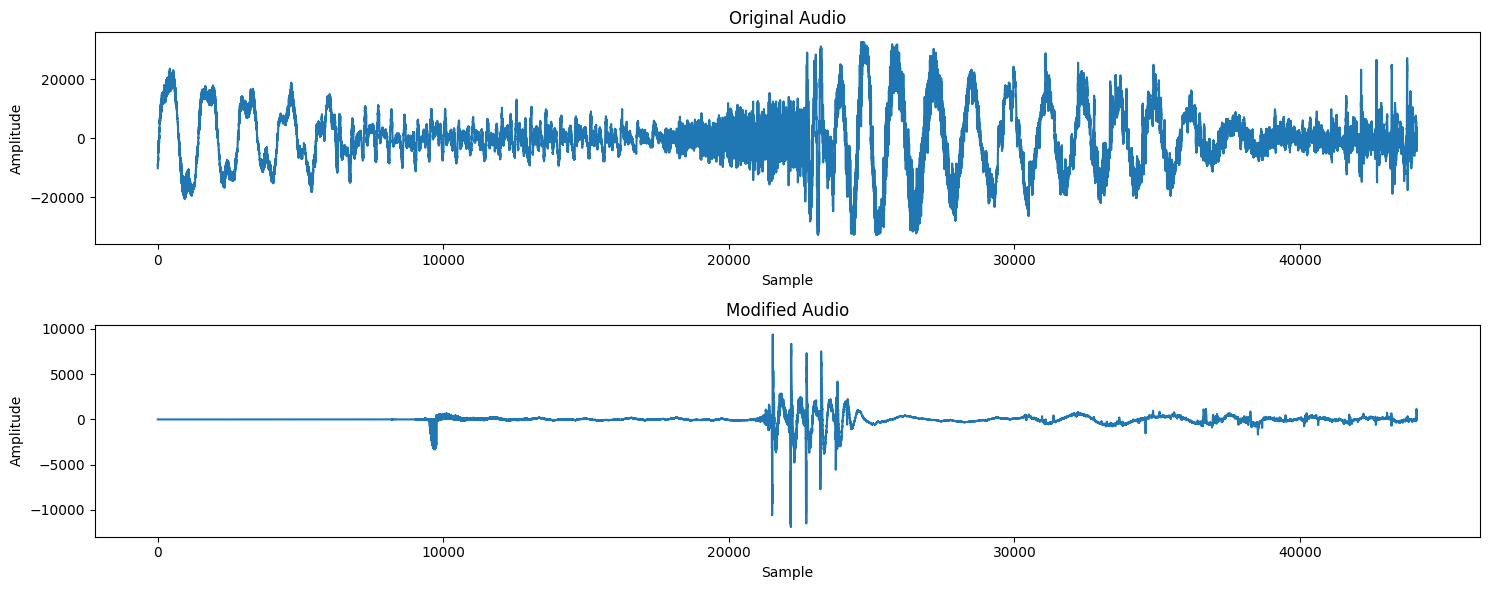

In [35]:
plot_audio_waveforms(original_segment_array, modified_audio_array, 0, len(original_segment_array))

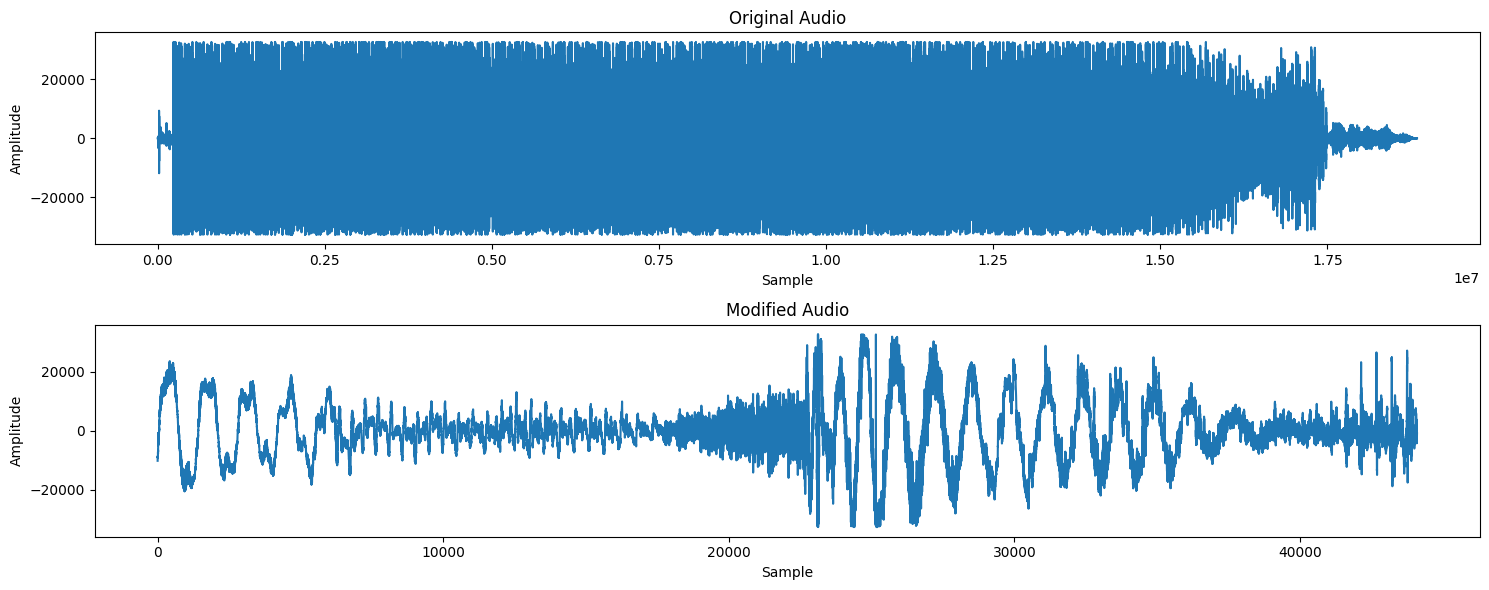

In [36]:
plot_audio_waveforms(original_segment_array_complete, modified_audio_array_complete, 0, len(original_segment_array_complete))